This notebook describes how to simulate the effects of biopsies and DNA sequencing on the observed clone sizes.   


This only works for the 2D algorithms (Moran2D and WF2D)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from clone_competition_simulation import Parameters, Gene, MutationGenerator, FixedValue
from clone_competition_simulation import get_vafs_for_all_biopsies, biopsy_sample, get_sample_dnds

# Counting mutant cells

In [3]:
# Run a 2D algorithm.  
# Here I'll run a simple simulation of neutral competition on a 10x10 grid
# Start with 100 single-cell clones, each with their own clone_id
np.random.seed(0)
p = Parameters(algorithm='Moran2D', initial_grid=np.arange(100).reshape(10, 10), print_warnings=False)
s = p.get_simulator()
s.run_sim()

In [4]:
# The final clone ids on the grid
s.grid_results[-1]

array([[18, 18, 18,  2,  2,  2, 15, 15, 24, 24],
       [24, 24, 18,  2,  2,  2,  2, 15, 18, 24],
       [24, 24, 54, 63, 63, 63, 63, 63, 50, 24],
       [18, 15, 54, 54, 63, 63, 63, 63, 63, 18],
       [24, 24, 54, 54, 15, 63, 63, 24, 59, 24],
       [24, 24, 24, 24, 54, 63, 63, 63, 59, 59],
       [59, 15, 59, 59, 24, 15, 63, 59, 59, 59],
       [59, 15, 59, 15, 15, 59, 63, 59, 59, 18],
       [18, 15, 15, 71, 71, 71, 18, 18, 59, 18],
       [18, 18, 71, 18, 71,  2, 18, 15, 86, 24]])

In [5]:
# To count the number of cells per clone in the grid, use the function biopsy_sample
biopsy_sample(s.grid_results[-1], s, biopsy=None, remove_initial_clones=False)

defaultdict(int,
            {2: 8,
             15: 13,
             18: 16,
             24: 18,
             50: 1,
             54: 6,
             59: 15,
             63: 17,
             71: 5,
             86: 1})

In [6]:
# To take a "biopsy" from the grid, define the biopsy location and dimensions
# The biopsies must be rectangular
biopsy = {
    'biopsy_origin': (3, 4),   # The coordinates of the first corner of the biopsy
    'biopsy_shape': (5, 3)   # The lengths of the sides of the biopsy
}

In [7]:
# These are the cells in the biopsy. 
# Equivalent to
# s.grid_results[-1][biopsy['biopsy_origin'][0]:biopsy['biopsy_origin'][0]+biopsy['biopsy_shape'][0], 
#                    biopsy['biopsy_origin'][1]:biopsy['biopsy_origin'][1]+biopsy['biopsy_shape'][1]]
s.grid_results[-1][3:3+5, 4:4+3]

array([[63, 63, 63],
       [15, 63, 63],
       [54, 63, 63],
       [24, 15, 63],
       [15, 59, 63]])

In [8]:
# Get a cell count for all of the clones in the biopsy.
biopsy_sample(s.grid_results[-1], s, biopsy, remove_initial_clones=False)

defaultdict(int, {15: 3, 24: 1, 54: 1, 59: 1, 63: 9})

Where there are mutations, and potentially multiple mutations in each cell, the biopsy_sample function becomes more useful.  

In [9]:
# Run a simulation with some ongoing mutation
np.random.seed(0)
p = Parameters(algorithm='Moran2D', initial_cells=100, 
               mutation_rates=0.1, print_warnings=False)
s = p.get_simulator()
s.run_sim()

In [10]:
# The final clone ids on the grid
s.grid_results[-1]

array([[ 99,   0,   0, 103, 100,   0,   0,  86, 109,   0],
       [  0,  89,  89,   0, 103,   0,   0,   0,   0,   0],
       [ 12,  12, 106, 106,   0,   0,   0,   0,   0,  56],
       [ 79,  12,   0,  62,   0,   0,   0,   0,  79,  79],
       [ 12,  12,  12,  56,   0,   0, 111,   0,   0,  97],
       [ 56, 101,  56,  56,  93,  26,   0,  79,   0, 101],
       [101,   0,  21,  21,  26,   0,   0,   0, 108,   0],
       [  0,  21,   0,  21,   0,   0,   0,   0, 104,   0],
       [  0,  36,  21,   0, 100,  98,   0,   0,   0,   0],
       [ 36,   0, 110,   0, 100,   0,   0, 112,   0,  99]])

In [11]:
# This is the biopsy we take
s.grid_results[-1][3:3+5, 4:4+3]

array([[  0,   0,   0],
       [  0,   0, 111],
       [ 93,  26,   0],
       [ 26,   0,   0],
       [  0,   0,   0]])

In [12]:
# Notice that now the cell counts per clone do not match the numbers in the grid. 
# This is because clones (and their mutations) are inherited by any subclones (which have a different clone_id).  
biopsy_sample(s.grid_results[-1], s, biopsy, remove_initial_clones=False)

defaultdict(int, {0: 15, 26: 2, 21: 2, 93: 1, 30: 1, 29: 1, 111: 1})

In [13]:
# Firstly, the clone with id=0 has 15 cells according to the function, but only 11 in the biopsy.   
# This is because clone_id 0 marks the clones that existed at the start of the simulation. 
# All subsequent mutations are descendants of that clone, 
# meaning that all 15 cells in the biopsy belong to clone_id 0 (and its subclones).   

In [14]:
# We can exclude any initial clones from the counts (this is the default behaviour)
# Now the count for clone_id=0 is gone. 
biopsy_sample(s.grid_results[-1], s, biopsy)

defaultdict(int, {26: 2, 21: 2, 93: 1, 30: 1, 29: 1, 111: 1})

In [15]:
# There is still the question of the clones with ids 21, 30 and 29.  
# According to the function, these clones are present in the grid, but those numbers are not there.  

# To see why, we can look at the descendants/subclones of those clones.  

# Clone 26 is a descendant of clone 21
s.get_clone_descendants(21)

[21, 26, 37, 62, 60, 68, 81]

In [16]:
# Clone 93 is a descendant of clone 30
s.get_clone_descendants(30)

[30, 38, 43, 44, 48, 53, 55, 63, 72, 93, 96]

In [17]:
# Clone 93 is also a descendant of clone 29
s.get_clone_descendants(29)

[29, 30, 38, 43, 44, 48, 53, 55, 63, 72, 93, 96]

So the mutations that originally formed the clones 21, 29 and 30 were inherited by subsequent (sub)clones and survive to the end. The function is counting the number of cells that contain each mutation. 

# Simulating sequencing

Usually the DNA sequencing cannot accurately measure the number of cells containing each mutation.  
Instead, it randomly samples DNA reads from a tissue sample, and the proportion of the sample containing the mutation is estimated based on the fraction of sampled reads that are mutant.   

In [18]:
# Run a larger simulation. (Run with WF2D because it is much faster)
mut_gen = MutationGenerator(genes=[Gene('Gene1', FixedValue(1.2), synonymous_proportion=0.5), 
                                  Gene('Gene2', FixedValue(1.4), synonymous_proportion=0.5), 
                                  Gene('Gene3', FixedValue(0.7), synonymous_proportion=0.5)], 
                           combine_mutations='add')

np.random.seed(0)
p = Parameters(algorithm='WF2D', initial_cells=10000, max_time=200, mutation_generator=mut_gen,
               mutation_rates=0.01, print_warnings=False)
s = p.get_simulator()
s.run_sim()

In [19]:
# This function tells us the exact cell counts for each mutation in the grid
exact_counts = biopsy_sample(s.grid_results[-1], s, biopsy=None)
exact_counts

defaultdict(int,
            {8327: 437,
             7410: 1634,
             6889: 1634,
             6419: 1634,
             4540: 1634,
             3353: 1634,
             2773: 1944,
             1589: 1944,
             1061: 1944,
             8521: 396,
             7216: 478,
             4654: 551,
             4254: 551,
             3563: 928,
             2785: 966,
             2104: 966,
             1186: 966,
             988: 966,
             8610: 1197,
             8655: 175,
             6462: 175,
             3047: 3517,
             2827: 3517,
             752: 3544,
             547: 3544,
             8867: 137,
             5992: 2245,
             5666: 2245,
             8959: 457,
             7859: 521,
             4921: 521,
             4704: 521,
             3043: 521,
             761: 521,
             553: 521,
             9065: 64,
             9115: 208,
             4158: 208,
             2410: 1323,
             2408: 1323,
            

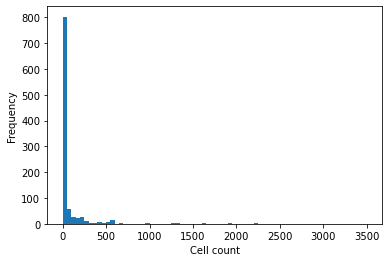

In [20]:
# There are many small clones, including many with just a few cells. 
plt.hist(exact_counts.values(), bins=np.arange(0, max(exact_counts.values())+1, 50));
plt.ylabel('Frequency')
plt.xlabel('Cell count');

In [21]:
# To convert this to variant allele frequency use this function
# This divides the cell number by the total cells in the grid
vafs = get_vafs_for_all_biopsies(s, biopsies=None, heterozygous=False)
vafs

,sample,vaf,gene,clone_id,ns
0,0,0.0437,Gene1,8327,True
1,0,0.1634,Gene2,7410,True
2,0,0.1634,Gene1,6889,True
3,0,0.1634,Gene1,6419,True
4,0,0.1634,Gene1,4540,True
...,...,...,...,...,...
1020,0,0.0004,Gene1,20000,False
1021,0,0.0003,Gene2,20001,True
1022,0,0.0001,Gene1,20003,False
1023,0,0.0001,Gene3,20004,True


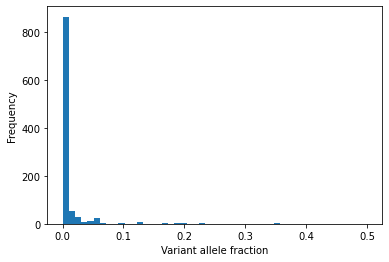

In [22]:
# Most clones in this case are a tiny fraction of the tissue size. 
# They would not be detected by most sequencing methods
plt.hist(vafs['vaf'], 
         bins=np.linspace(0, 0.5, 50));
plt.xlabel('Variant allele fraction')
plt.ylabel('Frequency');

In [23]:
# We can also simulate sequencing using get_vafs_for_all_biopsies.
# To get vafs for the entire grid, run get_vafs_for_all_biopsies with biopsies=None

# Define the sequencing coverage and a minimum number of "reads" required for a mutation to be detected.  
# Here we assume 100x coverage and a minimum detection limit of 5 reads. 
# The results are the VAFs of the detected clones. 
# The clones are by default assumed to be heterozygous (see below)
# These will be noisy, since there is random chance whether a "read" contains the mutation or not. 
# The smallest VAFs are now around 5% (5 reads out of the coverage of 100). 
get_vafs_for_all_biopsies(s, biopsies=None, detection_limit=5, coverage=100)

,sample,vaf,gene,clone_id,ns
0,0,0.11,Gene2,7410,True
1,0,0.07,Gene1,6889,True
2,0,0.06,Gene1,6419,True
3,0,0.11,Gene1,4540,True
4,0,0.06,Gene2,3353,True
5,0,0.12,Gene2,2773,True
6,0,0.09,Gene2,1589,True
7,0,0.07,Gene1,1061,True
8,0,0.07,Gene1,3563,True
9,0,0.23,Gene2,3047,True


In [24]:
# We can also simulate sequencing of a biopsy taken from the grid

biopsy = {
    'biopsy_origin': (30, 40),   # The coordinates of the first corner of the biopsy
    'biopsy_shape': (50, 30)   # The lengths of the sides of the biopsy
}

# "sequence" the mutations in the biopsy
get_vafs_for_all_biopsies(s, biopsies=[biopsy], detection_limit=5, coverage=100, heterozygous=False)

,sample,vaf,gene,clone_id,ns
0,0,0.23,Gene1,8327,True
1,0,0.35,Gene2,7410,True
2,0,0.35,Gene1,6889,True
3,0,0.39,Gene1,6419,True
4,0,0.32,Gene1,4540,True
5,0,0.40,Gene2,3353,True
6,0,0.53,Gene2,2773,True
7,0,0.51,Gene2,1589,True
8,0,0.46,Gene1,1061,True
9,0,0.20,Gene2,8610,True


In [25]:
# In many cases, mutations are heterozygous (on only one of two copies of the chromosome)
# To simulate this, set heterozygous=True (this is the default)
# The VAFs are now smaller (around half the size), and so usually fewer clones are detected
get_vafs_for_all_biopsies(s, biopsies=[biopsy], detection_limit=5, coverage=100, heterozygous=True)

,sample,vaf,gene,clone_id,ns
0,0,0.07,Gene1,8327,True
1,0,0.17,Gene2,7410,True
2,0,0.25,Gene1,6889,True
3,0,0.25,Gene1,6419,True
4,0,0.12,Gene1,4540,True
5,0,0.18,Gene2,3353,True
6,0,0.22,Gene2,2773,True
7,0,0.27,Gene2,1589,True
8,0,0.27,Gene1,1061,True
9,0,0.09,Gene2,5992,True


# Multiple biopsies

A list of biopies can be given.   
The clones detected from these biopsies can be merged (like the oesophagus grid-sequencing experiments in Martincorena and Fowler et al 2018).  

In [26]:
# Make a list of biopsies
biopsies = [
    {
        'biopsy_origin': (0, 0),   
        'biopsy_shape': (20, 20)
    }, 
    {
        'biopsy_origin': (20, 0),   
        'biopsy_shape': (20, 20)
    },
    {
        'biopsy_origin': (0, 20),   
        'biopsy_shape': (20, 20)
    },
    {
        'biopsy_origin': (20, 20),   
        'biopsy_shape': (20, 20)
    },
]

In [27]:
# This returns a data frame with information about all of the clones detected
get_vafs_for_all_biopsies(s, biopsies, detection_limit=5, coverage=100)

,sample,vaf,gene,clone_id,ns
0,0,0.22,Gene2,9160,True
1,0,0.26,Gene2,8391,True
2,0,0.25,Gene2,5757,True
3,0,0.22,Gene2,5036,True
4,0,0.22,Gene2,4297,True
...,...,...,...,...,...
89,3,0.54,Gene2,6655,False
90,3,0.27,Gene2,12706,True
91,3,0.06,Gene1,13973,True
92,3,0.19,Gene2,14164,True


In [28]:
# It merge_clones=True, the same clone seen in multiple samples will be treated as a single, larger clone
# The "vaf" in this case is just the sum of the VAFs.  
# If the biopsies are all the same size, then the VAF will be relative to the size of a single biopsy, 
# and vaf can be greater than 1. 
# If the biopsies are different sizes, it is better to use merge_clones=False and do the merging yourself to 
# get accurate sizes. 
get_vafs_for_all_biopsies(s, biopsies, detection_limit=5, coverage=100, merge_clones=True)

,vaf,gene,clone_id,ns
0,0.40,Gene2,9160,True
1,0.49,Gene2,8391,True
2,0.34,Gene2,5757,True
3,0.39,Gene2,5036,True
4,0.52,Gene2,4297,True
5,0.43,Gene2,1033,True
6,0.39,Gene2,337,True
7,0.20,Gene2,11862,True
8,0.19,Gene2,4890,True
9,0.51,Gene2,2410,True


# Selecting time points

In [33]:
# You don't have to use the final grid.  Instead, you can give a sample_num for the index of the 
# sample time you want.  
print('Time point:', s.times[10])

# Early on, there are fewer mutant clones large enough to detect
get_vafs_for_all_biopsies(s, biopsies, detection_limit=5, coverage=100, sample_num=10)

Time point: 20.0


,sample,vaf,gene,clone_id,ns
0,1,0.10,Gene2,26,True
1,1,0.14,Gene2,337,True
2,1,0.13,Gene2,1033,True
3,2,0.12,Gene2,547,True
4,2,0.06,Gene1,640,True
5,2,0.05,Gene2,535,True
6,2,0.09,Gene2,752,True


# Random coverage

In [30]:
# Instead of a fixed coverage, the coverage can be randomly drawn from a negative binomial distribution.
# The coverage is drawn independently for all mutations
get_vafs_for_all_biopsies(s, biopsies, detection_limit=5, binom=True, binom_params=(100, 0.5))

,sample,vaf,gene,clone_id,ns
0,0,0.215909,Gene2,9160,True
1,0,0.280899,Gene2,8391,True
2,0,0.275862,Gene2,5757,True
3,0,0.158879,Gene2,5036,True
4,0,0.240964,Gene2,4297,True
...,...,...,...,...,...
96,3,0.516129,Gene1,7386,True
97,3,0.451613,Gene2,6655,False
98,3,0.358696,Gene2,12706,True
99,3,0.148936,Gene2,14164,True


# dN/dS

In [31]:
# You can calculate dN/dS for the observed mutations. 
# This takes into account the expected proportion of synonymous and non-synonymous mutations for each gene
vafs = get_vafs_for_all_biopsies(s, biopsies=None)
print('Overall dN/dS', get_sample_dnds(vafs, s))
for i in range(1, 4):
    gene = f"Gene{i}"
    print(f'dN/dS for {gene}', get_sample_dnds(vafs, s, gene=gene))

Overall dN/dS 1.7553763440860215
dN/dS for Gene1 1.5819672131147542
dN/dS for Gene2 2.946564885496183
dN/dS for Gene3 0.6218487394957983


In [32]:
# dN/dS can vary greatly depending on the sequencing parameters
vafs = get_vafs_for_all_biopsies(s, biopsies=biopsies, detection_limit=4, coverage=500)
print('Overall dN/dS', get_sample_dnds(vafs, s))
for i in range(1, 4):
    gene = f"Gene{i}"
    print(f'dN/dS for {gene}', get_sample_dnds(vafs, s, gene=gene))

Overall dN/dS 4.4324324324324325
dN/dS for Gene1 3.2222222222222223
dN/dS for Gene2 7.444444444444445
dN/dS for Gene3 0.1
